```{contents}
```
## Entry Node

The **Entry Node** is the **starting execution point** of a LangGraph.
It defines **where the workflow begins**, determines the **initial transformation of state**, and anchors the entire control flow of the system.

In formal terms, the entry node is the **root of the directed execution graph**.

---

### **1. Why the Entry Node Matters**

Every LangGraph execution is a **state transition process**:

```
Initial State → [Entry Node] → State₁ → State₂ → … → Final State
```

Without a defined entry node:

* The graph has **no execution semantics**
* The runtime cannot determine **where to begin**
* State initialization becomes ambiguous

Thus, the entry node is **mandatory** for any executable LangGraph.

---

### **2. Conceptual Role of the Entry Node**

| Role              | Description                                        |
| ----------------- | -------------------------------------------------- |
| State initializer | First function to read initial input               |
| Control anchor    | Root of control-flow graph                         |
| Context builder   | Prepares state for downstream nodes                |
| System boundary   | Separates external input from internal computation |

It is equivalent to the **main()** function in a program.

---

### **3. Defining the Entry Node**

In LangGraph, the entry node is defined explicitly:

```python
builder.set_entry_point("ingest")
```

Where `"ingest"` is a previously registered node.

---

### **4. Execution Semantics**

When a graph is invoked:

```python
graph.invoke(input_state)
```

LangGraph internally executes:

```
current_node = entry_node
while current_node != END:
    state = current_node(state)
    current_node = next_node(state)
```

Thus, the entry node:

1. Receives the **external input state**
2. Produces the **first internal state update**
3. Triggers all subsequent transitions

---

### **5. Minimal Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    text: str
    tokens: list[str]

def ingest(state: State):
    return {"tokens": state["text"].split()}

def analyze(state: State):
    return {"tokens": [t.lower() for t in state["tokens"]]}

builder = StateGraph(State)

builder.add_node("ingest", ingest)
builder.add_node("analyze", analyze)

builder.set_entry_point("ingest")
builder.add_edge("ingest", "analyze")
builder.add_edge("analyze", END)

graph = builder.compile()
print(graph.invoke({"text": "Hello World"}))
```

**Execution Flow**

```
Input → ingest → analyze → END
```

---

### **6. Variants of Entry Nodes**

| Variant          | Purpose                       |
| ---------------- | ----------------------------- |
| Ingest Entry     | Raw input processing          |
| Router Entry     | Choose execution path         |
| Planner Entry    | Generate plan                 |
| Supervisor Entry | Multi-agent coordinator       |
| Validator Entry  | Input validation & sanitation |

---

### **7. Entry Node in Production Systems**

In production, the entry node often performs:

* Input validation
* Schema enforcement
* Authentication context injection
* Metadata attachment
* Conversation / session binding
* Safety filtering

This makes the entry node the **security and correctness gateway** of the entire system.

---

### **8. Entry Node vs First Node**

| Aspect             | Entry Node          | Regular Node                  |
| ------------------ | ------------------- | ----------------------------- |
| Position           | Always first        | Anywhere                      |
| Defined by         | `set_entry_point()` | `add_node()`                  |
| Receives raw input | Yes                 | No (receives processed state) |
| Can be changed     | Only before compile | Can be rewired                |

---

### **9. Mental Model**

Think of the Entry Node as:

> **The ignition key of the LangGraph engine**

Without turning it, nothing runs.

### Demonstration

In [1]:
from typing import TypedDict

class State(TypedDict):
    text: str
    tokens: list[str]
    is_question: bool

def ingest(state: State):
    # Entry Node: transforms raw input into structured form
    return {"tokens": state["text"].split()}

def validate(state: State):
    return {"is_question": state["text"].endswith("?")}

def process_question(state: State):
    return {"tokens": [t.upper() for t in state["tokens"]]}

def process_statement(state: State):
    return {"tokens": [t.lower() for t in state["tokens"]]}


In [2]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("ingest", ingest)
builder.add_node("validate", validate)
builder.add_node("question", process_question)
builder.add_node("statement", process_statement)

builder.set_entry_point("ingest")

builder.add_edge("ingest", "validate")

builder.add_conditional_edges(
    "validate",
    lambda s: "question" if s["is_question"] else "statement",
    {
        "question": "question",
        "statement": "statement"
    }
)

builder.add_edge("question", END)
builder.add_edge("statement", END)

graph = builder.compile()


In [3]:
print(graph.invoke({"text": "How are you?"}))
print(graph.invoke({"text": "I am learning LangGraph"}))


{'text': 'How are you?', 'tokens': ['HOW', 'ARE', 'YOU?'], 'is_question': True}
{'text': 'I am learning LangGraph', 'tokens': ['i', 'am', 'learning', 'langgraph'], 'is_question': False}


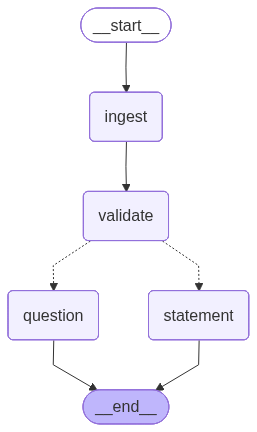

In [6]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())